In [ ]:
# Import libraries
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Activation,Conv2D,MaxPooling2D,add,Dropout,Flatten,Dense
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_path = "/content/drive/MyDrive/dataset/train"
validation_data_path = "/content/drive/MyDrive/dataset/valid"

In [ ]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_data_path, # this is the target directory
                                      target_size=(224, 224), # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 10618 images belonging to 2 classes.


In [ ]:
# this is the augmentation configuration we will use for validation:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
valid_data = valid_datagen.flow_from_directory(validation_data_path,
                                  target_size=(224,224),
                                  batch_size=32,
                                  class_mode='binary')

Found 1621 images belonging to 2 classes.


In [ ]:
training_data.class_indices

{'with_mask': 0, 'without_mask': 1}

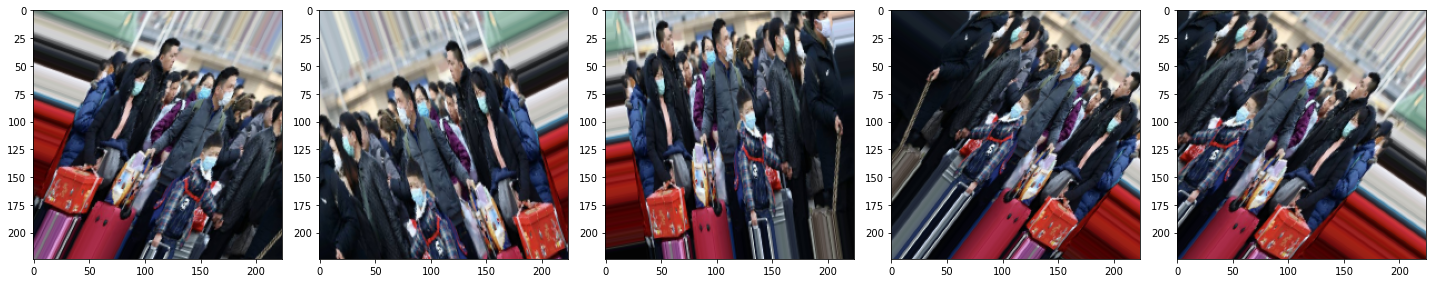

In [ ]:
# showing augmented images
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

In [ ]:
# save best model using vall accuracy
model_path = '/content/drive/MyDrive/dataset/face_mask_neil_model.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	adding_all = concatenate([conv1, conv3, conv5, pool], axis=-1)
  # add skip connection
	layer_out = concatenate([adding_all,layer_in], axis=-1)
  # activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out

def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
	# activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 111, 111, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 111, 111, 16) 528         max_pooling2d[0][0]              
______________________________________________________________________________________________

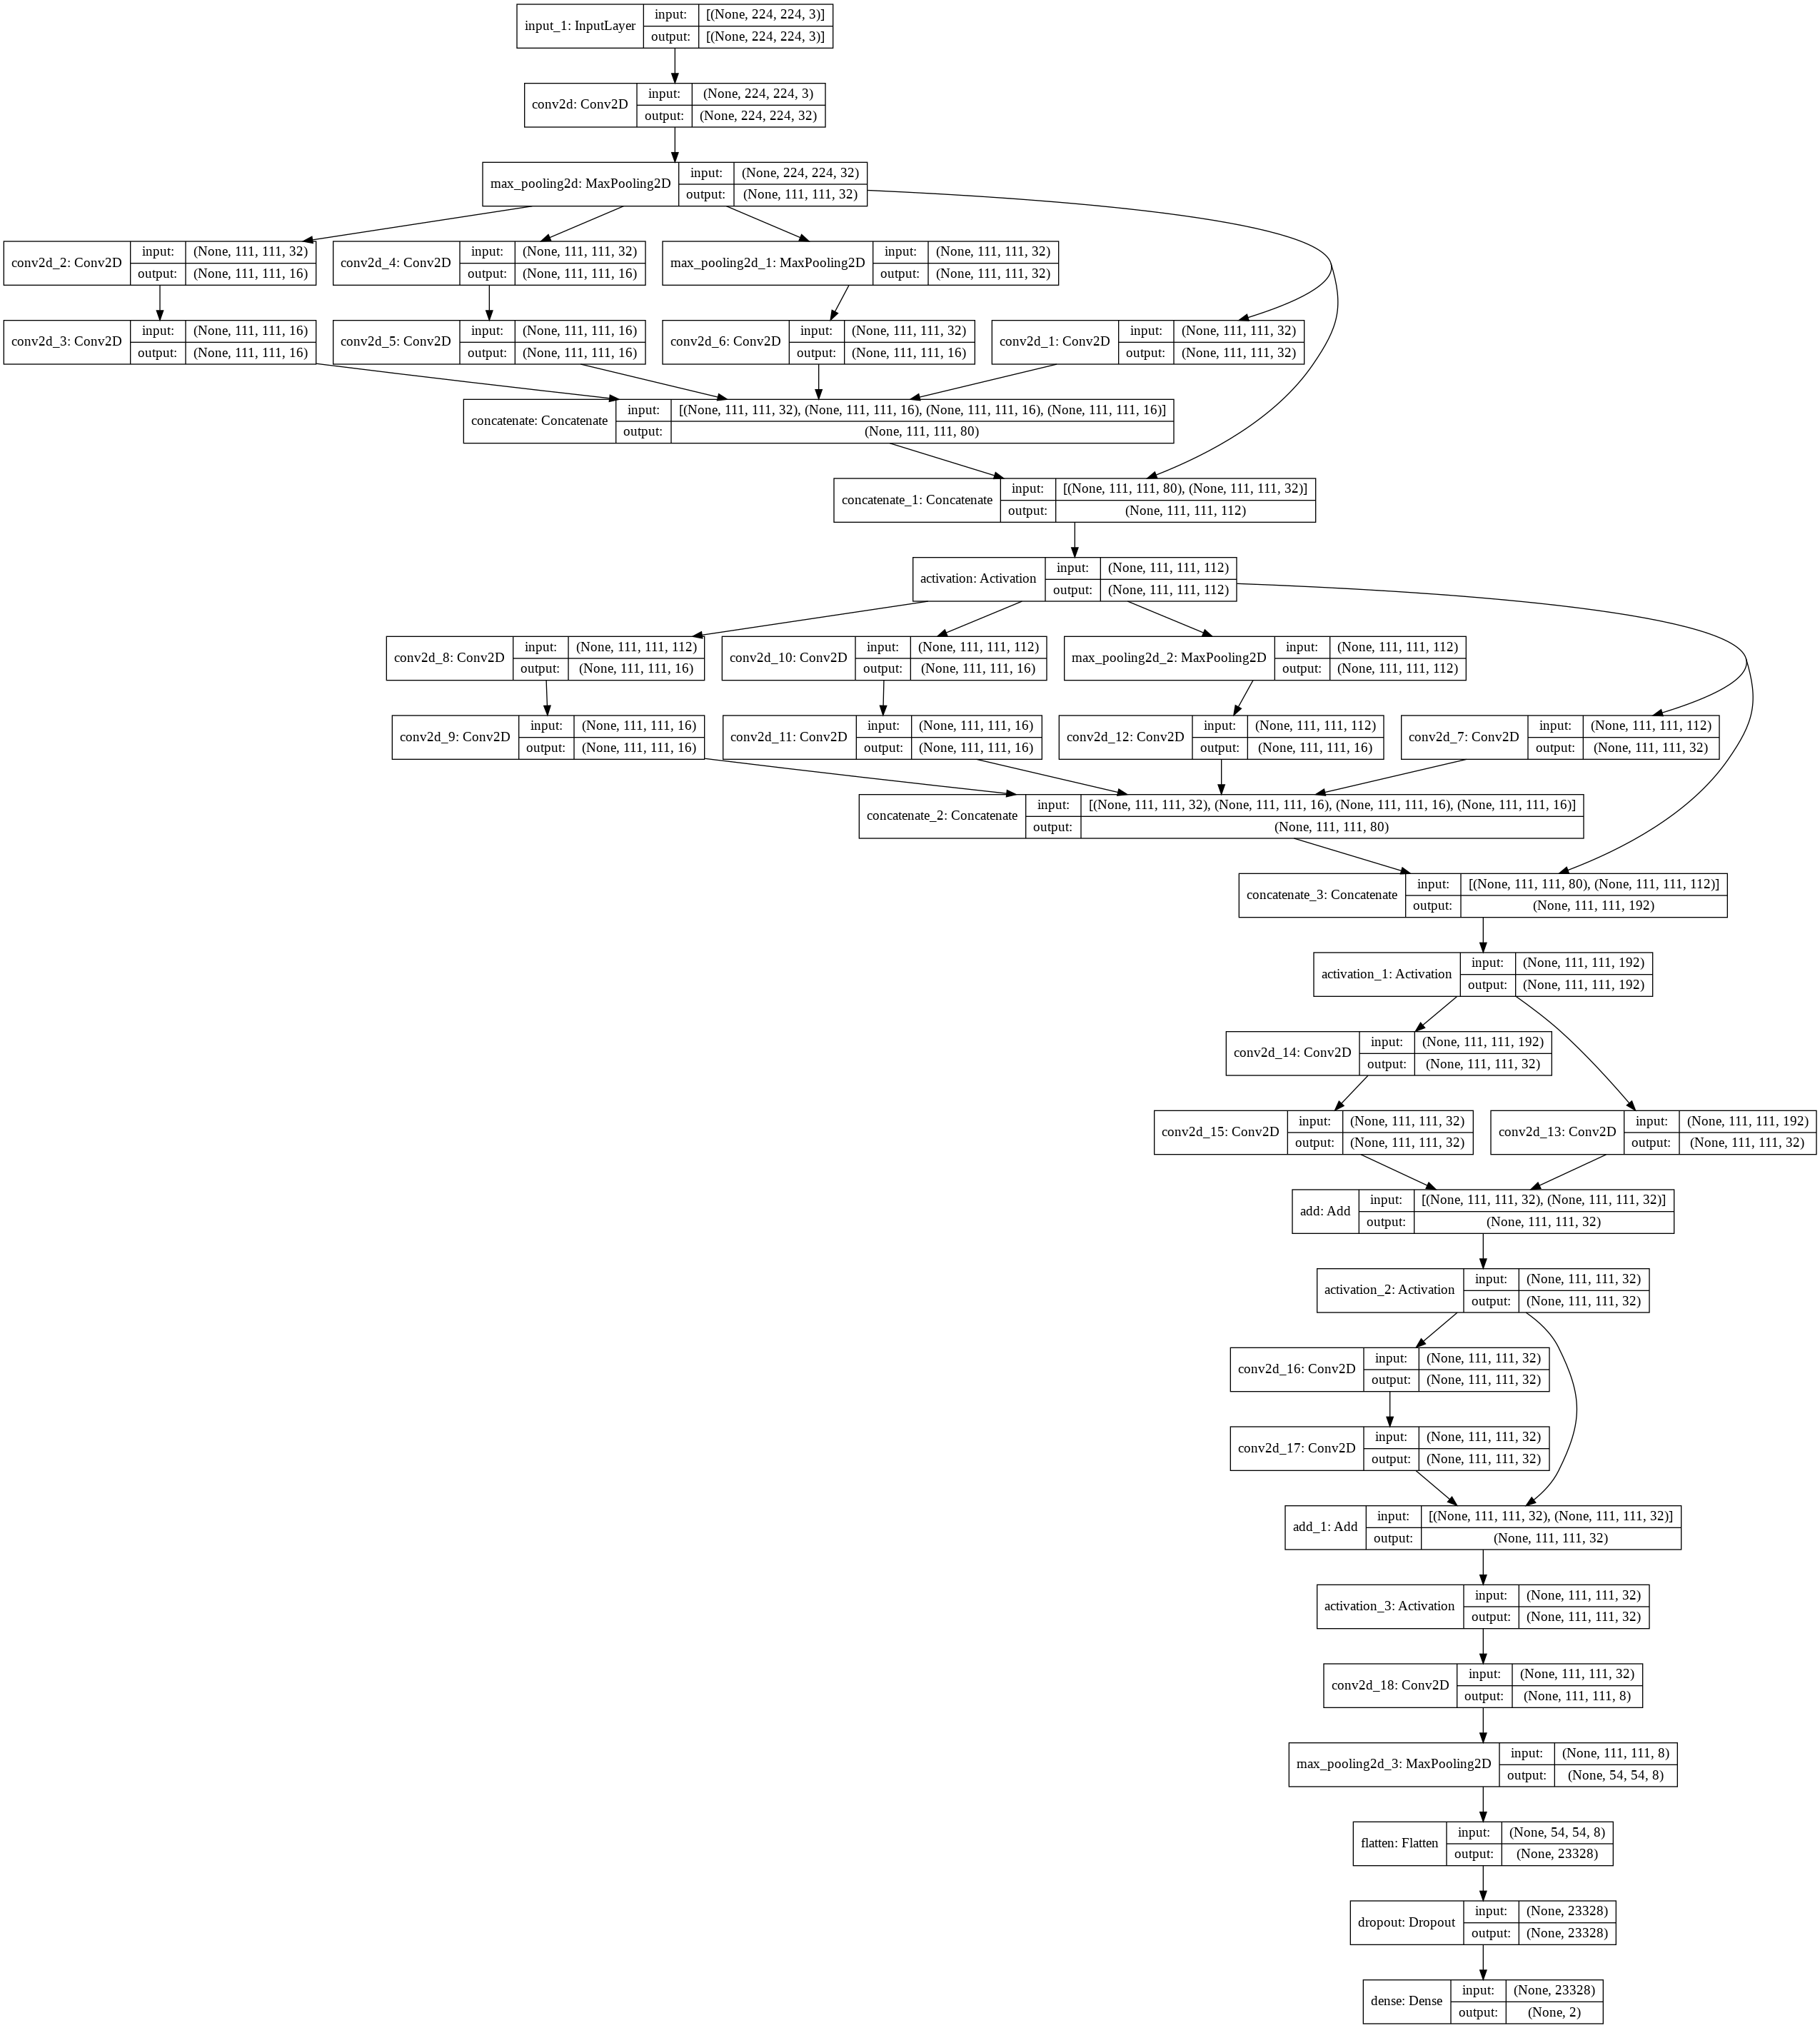

In [ ]:
# define model input
visible = Input(shape=(224, 224, 3))

layer = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(visible)
layer = MaxPooling2D((3,3), strides=(2,2), padding='valid')(layer)

layer = inception_module(layer, 32, 16, 16, 16, 16, 16)
layer = inception_module(layer, 32, 16, 16, 16, 16, 16)
layer = residual_module(layer, 32)
layer = residual_module(layer, 32)

layer = Conv2D(8, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer)
layer = MaxPooling2D((5,5), strides=(2,2), padding='valid')(layer)

layer = Flatten()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=2, activation='softmax')(layer)

# create model
cnn_model = Model(inputs=visible, outputs=layer)
# summarize model
cnn_model.summary()
# plot model architecture
plot_model(cnn_model, show_shapes=True, to_file='residual_module.png')

In [ ]:
# compile cnn model
cnn_model.compile(optimizer = Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train cnn model
history = cnn_model.fit(training_data, 
                          epochs=50, 
                          verbose=1, 
                          validation_data= valid_data,
                          callbacks=callbacks_list)

Epoch 1/50
311/332 [===========================>..] - ETA: 3:07 - loss: 0.4890 - accuracy: 0.7791

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


332/332 [==============================] - 3376s 10s/step - loss: 0.4805 - accuracy: 0.7840 - val_loss: 0.2848 - val_accuracy: 0.9099

Epoch 00001: val_accuracy improved from -inf to 0.90993, saving model to /content/drive/MyDrive/dataset/face_mask_neil_model.h5
Epoch 2/50
332/332 [==============================] - 161s 484ms/step - loss: 0.2621 - accuracy: 0.9014 - val_loss: 0.1877 - val_accuracy: 0.9371

Epoch 00002: val_accuracy improved from 0.90993 to 0.93708, saving model to /content/drive/MyDrive/dataset/face_mask_neil_model.h5
Epoch 3/50
332/332 [==============================] - 160s 482ms/step - loss: 0.2413 - accuracy: 0.9077 - val_loss: 0.1981 - val_accuracy: 0.9377

Epoch 00003: val_accuracy improved from 0.93708 to 0.93769, saving model to /content/drive/MyDrive/dataset/face_mask_neil_model.h5
Epoch 4/50
332/332 [==============================] - 160s 482ms/step - loss: 0.2260 - accuracy: 0.9195 - val_loss: 0.1594 - val_accuracy: 0.9432

Epoch 00004: val_accuracy improved

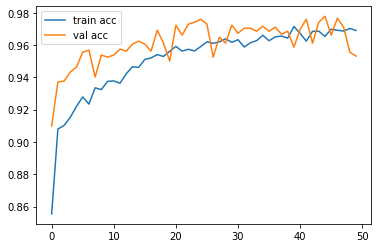

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')